# Libraries

In [1]:
from sklearn import metrics
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import hdbscan
import pandas as pd
import numpy as np
import pylab as py
import matplotlib.pyplot as plt

from matplotlib.cm import get_cmap
import matplotlib
# for condense trees in hdbscan
import seaborn as sns

%matplotlib inline

In [2]:
dataset = pd.read_csv('Tennessee_Event-Driven/datasets/dataset_standard_scaled.csv',index_col=False)

# 1 Density-based clustering

## 1.1 DBSCAN

### 1.1.1 Set the epsilon range according to guidelines
1. We start by setting MinPts value. Authors in [1, 2] recommend setting the value to MinPts>=2\*D whereas research community often recommends MinPts>=D+1 as a general rule (or rule of thumb). We narrow the range of MinPts parameter to two values. We denote them as rule of thumb \#1 (MinPts=2\*D), \#2 (MinPts=D+1)

2. We set the range of epsilon values by plotting a sorted k-distance plot that shows sorted distance of each point to k-th neighbor, as described by authors of DBSCAN, and according to their recommendations we search for a knee and explore the values between 70th and 95th percentile

[1] M. Ester, H.-P. Kriegel, J. Sander, X. Xu, et al., “A density-based algorithm for discovering clusters in large spatial databases with noise.,” in Kdd, vol. 96, pp. 226–231, 1996.  
[2] J. Sander, M. Ester, H.-P. Kriegel, and X. Xu, “Density-based clustering in spatial databases: The algorithm gdbscan and its applications,” Data mining and knowledge discovery, vol. 2, no. 2, pp. 169–194, 1998.

In [3]:
ground_truth = dataset['fault_id'].copy()
dataset.drop(columns=['fault_id'],inplace=True)

In [4]:
# rule of thumb 1 - minpts >=2*D ; number_of_neighbors = minpts-1 -> 2*D-1
n_nbrs1 = 2*len(dataset.columns.values) - 1
nbrs1 = NearestNeighbors(n_neighbors=n_nbrs1).fit(dataset.values)
distances1, indices1 = nbrs1.kneighbors(dataset.values)
# rule of thumb 2 : minpts >= D+1 ; number_of_neighbors = minpts-1 -> D
n_nbrs2 = len(dataset.columns.values)
nbrs2 = NearestNeighbors(n_neighbors=n_nbrs2).fit(dataset.values)
distances2, indices2 = nbrs2.kneighbors(dataset.values)

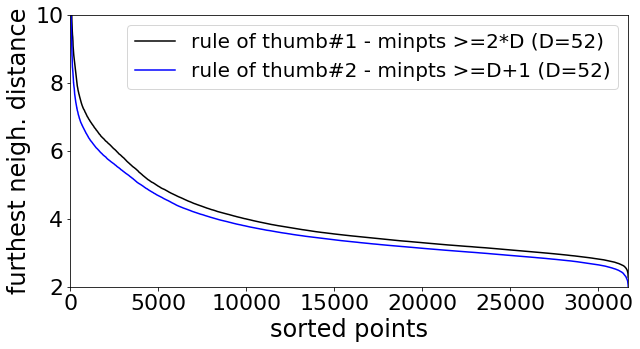

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.sort(distances1[:,n_nbrs1-1])[::-1], color='black')
ax.plot(np.sort(distances2[:,n_nbrs2-1])[::-1], color='blue')
ax.set_xlim([0,len(dataset)])
ax.set_ylim([2,10])
ax.tick_params(labelsize=22)
ax.set_xlabel('sorted points',size=24)
ax.set_ylabel('furthest neigh. distance',size=24)

ax.legend(['rule of thumb#1 - minpts >=2*D (D=' + str(len(dataset.columns)) + ')'\
           ,'rule of thumb#2 - minpts >=D+1 (D=' + str(len(dataset.columns)) + ')'], fontsize=20)

In [6]:
print('Rule of thumb#1 50th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],50)))
print('Rule of thumb#1 90th percentile: ' +str(np.percentile(distances1[:,n_nbrs1-1],90)))

Rule of thumb#1 50th percentile: 3.5062340059256094
Rule of thumb#1 90th percentile: 5.723375145747552


### 1.1.2 DBSCAN for a set of parameters

In [ ]:
labels_list = list()
min_samples_list = [104, 53]

# standard scaled
eps_list = [3.5,3.6,3.7,3.8,3.9,4,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6]
# original
#eps_list = [20,25,30,35,40,45,50,55,60,65,70,75,80]

for min_samples in min_samples_list:
    for eps in eps_list:
        dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples).fit(dataset.values)
        labels_list.append(dbscan_clust.labels_)

min_samples_list_df = [min_samples_list[0] for i in range(len(eps_list))]
min_samples_list_df.extend([min_samples_list[1] for i in range(len(eps_list))])
eps_list.extend(eps_list)
dbscan_results = {'min_samples' : min_samples_list_df,
                       'eps' : eps_list,
                       'labels' : labels_list}
dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df.to_pickle('Tennessee_Event-Driven/results/tep_all_dbscan_results_df.csv')

In [ ]:
dbscan_results_df = pd.read_pickle('Tennessee_Event-Driven/results/tep_all_dbscan_results_df.csv')

### 1.1.3 DBSCAN evaluation : V-measure

In [ ]:
v_measure_list = list()
homogeneity_list = list()
completeness_list = list()
noise_index_list = list()
clusters_index_list = list()
clusters_labels_list = list()

for labels,i in zip(dbscan_results_df['labels'],range(len(dbscan_results_df['labels']))):
    noise_index = np.where(labels==-1)[0]
    noise_index_list.append(noise_index)
    clusters_index = np.where(labels!=-1)[0]
    clusters_index_list.append(clusters_index)
    clusters_labels = labels[clusters_index]
    clusters_labels_list.append(clusters_labels)
    # clusters v-measure
    hom,comp,vm = metrics.homogeneity_completeness_v_measure(ground_truth[clusters_index], clusters_labels)
    homogeneity_list.append(hom)
    completeness_list.append(comp)
    v_measure_list.append(vm)
    
dbscan_results_df['v measure'] = v_measure_list
dbscan_results_df['homogeneity'] = homogeneity_list
dbscan_results_df['completeness'] = completeness_list
dbscan_results_df['noise_index'] = noise_index_list
dbscan_results_df['clusters_index'] = clusters_index_list
dbscan_results_df['clusters_labels'] = clusters_labels_list
dbscan_results_df.to_pickle('Tennessee_Event-Driven/results/tep_all_dbscan_results_df_eval.csv')

### 1.1.4 DBSCAN results analysis

In [41]:
dbscan_results_df = pd.read_pickle('Tennessee_Event-Driven/results/tep_all_dbscan_results_df_eval.csv')

In [43]:
number_of_clusters = list()
for clusters_labels in dbscan_results_df['clusters_labels']:
    number_of_clusters.append(len(np.unique(clusters_labels)))
dbscan_results_df['number_of_clusters'] = number_of_clusters

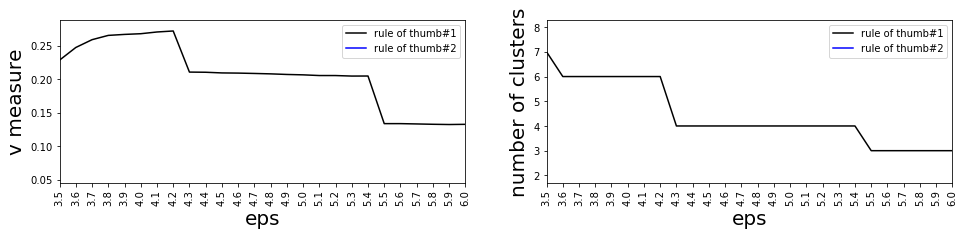

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
def apply_plt(ax):
    ax.set_xlim([0,len(dbscan_results_df)/2-1])
    ax.set_xticks(range(dbscan_results_df['eps'].nunique()))
    ax.set_xticklabels(dbscan_results_df['eps'].unique(),rotation='vertical')
    ax.tick_params(labelsize=10)
    ax.set_xlabel('eps',size=20)
    ax.legend(['rule of thumb#1', 'rule of thumb#2'], fontsize=10)

ax[0].plot(dbscan_results_df[dbscan_results_df['min_samples']==104]['v measure'], color='black')
ax[0].plot(dbscan_results_df[dbscan_results_df['min_samples']==53]['v measure'], color='blue')
#ax.set_ylim([2,10])
ax[0].set_ylabel('v measure',size=20)
apply_plt(ax[0])

ax[1].plot(dbscan_results_df[dbscan_results_df['min_samples']==104]['number_of_clusters'], color='black')
ax[1].plot(dbscan_results_df[dbscan_results_df['min_samples']==53]['number_of_clusters'], color='blue')
#ax.set_ylim([2,10])
ax[1].set_ylabel('number of clusters',size=20)
apply_plt(ax[1])

## 1.2 OPTICS
We set the OPTICS Xi by analyzing values that are able to mark start/end of interesting valleys identifying clusters in reachability plot.

In [7]:
dataset = dataset.drop(columns=['fault_id'])
ordered_reachability_list = list()
ordered_labels_list = list()
ordered_core_distances_list = list()

reachability_list = list()
labels_list = list()
core_distances_list = list()

cluster_hierarchy_list = list()
samples_ordering_list = list()
xi_list = [0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]

# min_cluster_size value is used during cluster extraction, default = 10, in this case it shouldn't mater much
for xi in xi_list:
    optics_clust = OPTICS(min_samples=104, xi=xi, min_cluster_size=10)
    optics_clust.fit(dataset.values)

    ordered_reachability_list.append(optics_clust.reachability_[optics_clust.ordering_])
    ordered_labels_list.append(optics_clust.labels_[optics_clust.ordering_])
    ordered_core_distances_list.append(optics_clust.core_distances_[optics_clust.ordering_])

    reachability_list.append(optics_clust.reachability_)
    labels_list.append(optics_clust.labels_)
    core_distances_list.append(optics_clust.core_distances_)

    cluster_hierarchy_list.append(optics_clust.cluster_hierarchy_)
    samples_ordering_list.append(optics_clust.ordering_)

# save/load results
optics_results = {'xi' : xi_list,
                       'ordered_samples' : samples_ordering_list,
                       'ordered_reachability' : ordered_reachability_list,
                       'ordered_core_distances' : ordered_core_distances_list,
                       'ordered_clusters_labels' : ordered_labels_list,
                       'reachability' : reachability_list,
                       'core_distances' : core_distances_list,
                       'clusters_labels' : labels_list,
                       'cluster_hierarchy' : cluster_hierarchy_list}
optics_results_df = pd.DataFrame(optics_results)

optics_results_df.to_pickle('Tennessee_Event-Driven/results/tep_optics_results_orig_df.csv')

### 1.2.1 OPTICS results evaluation

In [4]:
optics_results_df = pd.read_pickle('Tennessee_Event-Driven/results/tep_optics_results_df.csv')

Text(0.08, 0.5, 'reachability distance')

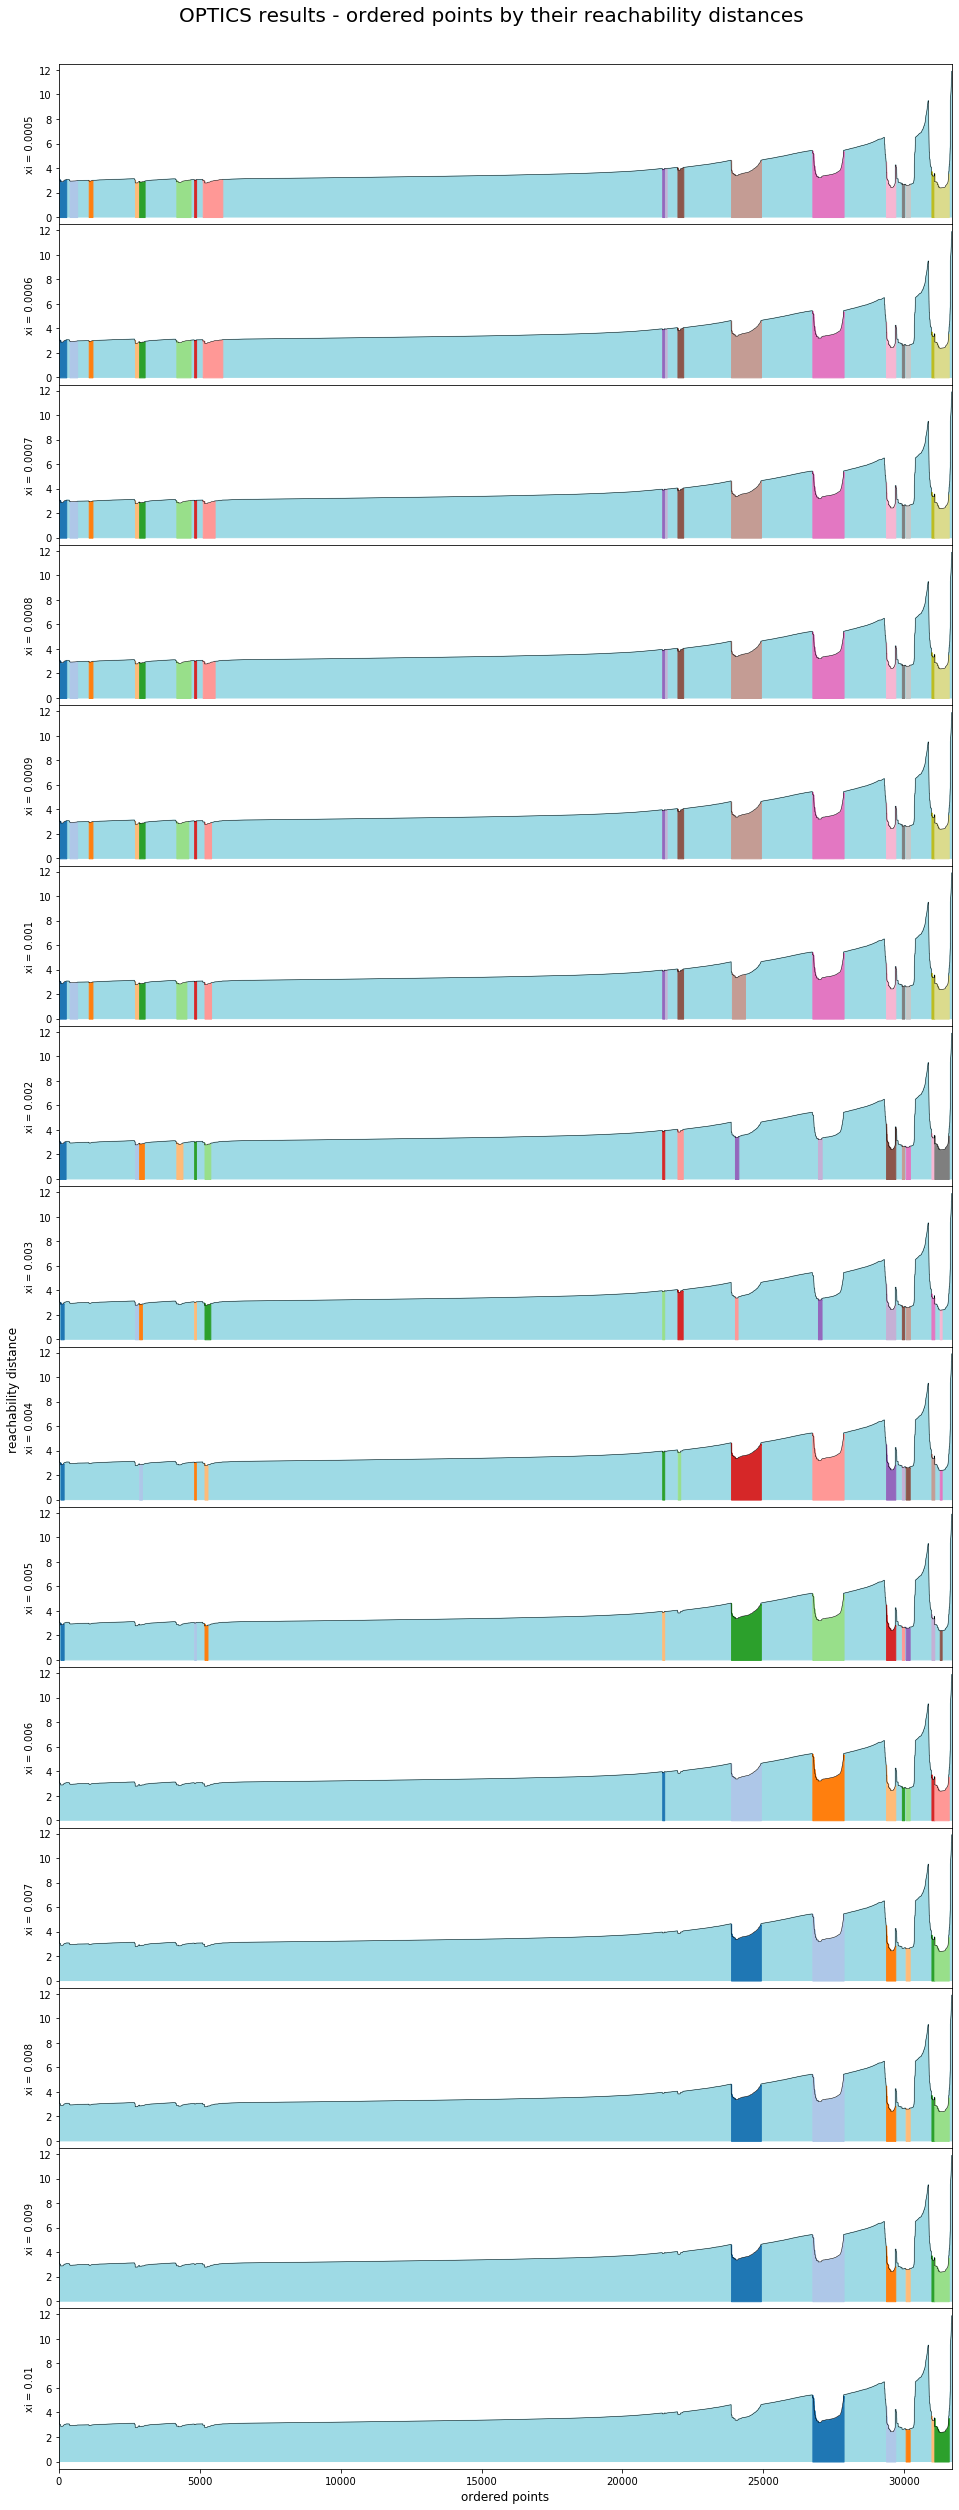

In [6]:
# list of colormaps https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
cmap = get_cmap('tab20')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots(len(optics_results_df['xi']), 1, figsize=(16,40) , sharex=True)

fig.suptitle('OPTICS results - ordered points by their reachability distances', size=20)

for j in range(len(optics_results_df['xi'])):
    ax[j].plot(optics_results_df['ordered_reachability'][j],color='black',linewidth=0.5)
    ax[j].set_xlim([0, len(optics_results_df['ordered_reachability'][j])])
    ax[j].set_ylabel('xi = ' + str(optics_results_df['xi'][j]))
    #ax[j].set_ylim([0,10])
    ax[j].set_xlabel('ordered points',size=12)
    
    # start color filling from parents to children - ie. from back to front
    for i in np.unique(optics_results_df['ordered_clusters_labels'][j]):
        # np.mod cycles through the color set in case there is more clusters than colors
        cluster_x_not = np.where(optics_results_df['ordered_clusters_labels'][j]!=i)[0]
        cluster_y = optics_results_df['ordered_reachability'][j].copy()
        cluster_y[cluster_x_not] = 0
        ax[j].fill_between(np.linspace(0,len(dataset_scaled)-1,len(dataset_scaled),endpoint=True), cluster_y, where=cluster_y>0, interpolate=True, color=colors[np.mod(i,len(colors))])
plt.subplots_adjust(hspace = 0,top=0.96)
fig.text(0.08, 0.5, 'reachability distance', va='center', rotation='vertical',size=12)